### Individual Assignment (Big Data Programming)
#### Name               = Hlaing Win Tun
#### Admission No. = 2082073D
#### Application      = Car Price Prediction and Analysis

### Loading the Data

First, load the dataset into a DataFrame.

In [1]:
toyotaDF = spark.read.csv("/home/training/bdpg/Assignment/toyota.csv", inferSchema=True, header=True)
toyotaDF.printSchema()
toyotaDF.show(5, truncate=False)

root
 |-- id: integer (nullable = true)
 |-- model: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- transmission: string (nullable = true)
 |-- mileage: integer (nullable = true)
 |-- fuelType: string (nullable = true)
 |-- tax: integer (nullable = true)
 |-- mpg: double (nullable = true)
 |-- engineSize: double (nullable = true)

+---+-----+----+-----+------------+-------+--------+---+----+----------+
|id |model|year|price|transmission|mileage|fuelType|tax|mpg |engineSize|
+---+-----+----+-----+------------+-------+--------+---+----+----------+
|1  | GT86|2016|16000|Manual      |24089  |Petrol  |265|36.2|2.0       |
|2  | GT86|2017|15995|Manual      |18615  |Petrol  |145|36.2|2.0       |
|3  | GT86|2015|13998|Manual      |27469  |Petrol  |265|36.2|2.0       |
|4  | GT86|2017|18998|Manual      |14736  |Petrol  |150|36.2|2.0       |
|5  | GT86|2017|17498|Manual      |36284  |Petrol  |145|36.2|2.0       |
+---+-----+----+-----+----

### Data Cleaning
#### Remove Duplicates
From the resulting DataFrame, Remove duplicates (records that are exact copies of each other within the subset)

In [2]:
print(f"Count of dataset before data cleaning => ", toyotaDF.count())

car_df = toyotaDF.dropDuplicates(subset=["model", "year", "price", "transmission", 
                                         "mileage", "fuelType", "tax", "mpg", "engineSize"]);

print(f"Count of dataset after removing duplicate records => ", car_df.count())

Count of dataset before data cleaning =>  6742
Count of dataset after removing duplicate records =>  6699


#### Missing Observations 
Find the missing observations by generate the percentage of missing observations in each column.

In [3]:
import pyspark.sql.functions as fn
car_df.agg( * [(1 - fn.count(c) / fn.count("*")).alias(c + '_missing') for c in car_df.columns] 
          ).show(vertical=True)

-RECORD 0------------------------------------
 id_missing           | 0.0                  
 model_missing        | 0.0                  
 year_missing         | 1.492760113449565E-4 
 price_missing        | 0.0                  
 transmission_missing | 1.492760113449565E-4 
 mileage_missing      | 0.0                  
 fuelType_missing     | 1.492760113449565E-4 
 tax_missing          | 0.0                  
 mpg_missing          | 0.0                  
 engineSize_missing   | 0.0                  



There are still missing observations in the year, transmision, fuelType columns. Since the number of records containing missing values are small, hence drop these records from the DataFrame.

In [3]:
car_df.where( (car_df.year.isNull()) | (car_df.transmission.isNull()) | (car_df.fuelType.isNull())).show(10)
car_df_clean_misingrecords = car_df.dropna(subset=["year", "transmission", "fuelType"])
print(f"Count of dataset after removing the missing records => ", car_df_clean_misingrecords.count())

+---+-----+----+-----+------------+-------+--------+---+----+----------+
| id|model|year|price|transmission|mileage|fuelType|tax| mpg|engineSize|
+---+-----+----+-----+------------+-------+--------+---+----+----------+
|  8| GT86|null|18995|      Manual|  12340|  Petrol|145|36.2|       2.0|
|  6| GT86|2017|15998|      Manual|  26919|    null|260|36.2|       2.0|
| 14| GT86|2019|23995|        null|    995|  Petrol|145|33.2|       2.0|
+---+-----+----+-----+------------+-------+--------+---+----+----------+

Count of dataset after removing the missing records =>  6696


Notice that there are spaces that are in model column which infront of the car model text. Let us remove them:

In [4]:
from pyspark.sql import functions as fn
car_df1 = car_df_clean_misingrecords.withColumn("model", fn.regexp_replace("model", ' ', ''))
car_df1.show(10)

+----+-------+----+-----+------------+-------+--------+---+----+----------+
|  id|  model|year|price|transmission|mileage|fuelType|tax| mpg|engineSize|
+----+-------+----+-----+------------+-------+--------+---+----+----------+
|  27|   GT86|2016|15995|   Semi-Auto|  19460|  Petrol|200|39.8|       2.0|
| 160|Corolla|2019|20990|      Manual|   8503|  Petrol|150|39.2|       1.2|
| 218|Corolla|2019|21999|   Automatic|   8171|  Hybrid|135|78.5|       1.8|
| 417|   RAV4|2014|10995|      Manual|  59627|  Diesel|125|57.6|       2.0|
| 598|   RAV4|2016|19490|   Automatic|   6254|  Petrol|200|43.5|       2.0|
| 614|   RAV4|2013|12295|      Manual|  43573|  Diesel|125|57.6|       2.0|
| 882|  Yaris|2013| 6998|      Manual|  17121|  Petrol|125|51.4|       1.3|
| 923|  Yaris|2017| 9998|      Manual|  22500|  Petrol|145|55.0|       1.3|
|1309|  Yaris|2018| 9788|      Manual|  12550|  Petrol|145|58.9|       1.5|
|1340|  Yaris|2015| 7495|      Manual|  24000|  Petrol| 30|58.0|       1.3|
+----+------

Notice that the transmission is typically 'Automatic' or 'Manual' but there are records with transmission "Auto". It would be good to standardise the values in the transmission column by replacing occurences of "Auto" with "Automatic".
Notice one more is that car model "Corola" spelling have to correct with "Corolla".

In [6]:
car_df2 = car_df1.filter( (car_df1.model == "Corola") | (car_df1.transmission == "Auto"))
car_df2.show()

car_df3 = car_df1.replace(["Corola", "Auto"], ["Corolla", "Automatic"], ["model", "transmission"])
car_df3.filter( (car_df3.model == "Corola") | (car_df3.transmission == "Auto")).count()

+----+------+----+-----+------------+-------+--------+---+----+----------+
|  id| model|year|price|transmission|mileage|fuelType|tax| mpg|engineSize|
+----+------+----+-----+------------+-------+--------+---+----+----------+
|1868| Yaris|2019|17589|        Auto|   2251|  Petrol|145|47.9|       1.5|
|1911| Yaris|2016|12295|        Auto|  13849|  Hybrid|  0|86.0|       1.5|
| 104|Corola|2019|18498|      Manual|   5087|  Petrol|145|39.2|       1.2|
|1883| Yaris|2015|12000|        Auto|   7929|  Hybrid|  0|78.0|       1.5|
|  96|Corola|2019|21995|   Automatic|   9100|  Hybrid|135|58.9|       1.8|
| 100|Corola|2019|21998|   Automatic|   9023|  Hybrid|135|72.4|       2.0|
+----+------+----+-----+------------+-------+--------+---+----+----------+



0

#### Write DataFrame

Save data frame as csv to visualize outliers values using tableau

In [7]:
car_df3.coalesce(1).write.format("csv").option('header'
                                               ,True).option("compression",
                                                             "gzip").mode('overwrite').save("/home/training/Downloads/outliers-toyota")

#### Outliers
Find the outliers for the price column. First, we calculate the upper and lower cut off points for the price column using the approxQuantile method. After that, remove records having the outlier values. 

In [9]:
print(f"Count of dataset before removing outlier values = ", car_df3.count())
quantiles = car_df3.approxQuantile("price", [0.25, 0.75], 0.05)
IQR = quantiles[1] - quantiles[0]
bounds = [ quantiles[0] - 1.5 * IQR, quantiles[1] + 1.5 * IQR ]
car_df4 =car_df3.filter( (car_df3.price >= bounds[0]) & (car_df3.price <= bounds[1]) )
print(f"Count of dataset after removing outlier values = ", car_df4.count())

Count of dataset before removing outlier values =  6696
Count of dataset after removing outlier values =  6210


#### Write DataFrame
Save clean data frame as csv to visualize business analytics insights using tableau

In [10]:
car_df4.coalesce(1).write.format("csv").option('header'
                                               ,True).option("compression"
                                                             ,"gzip").mode('overwrite').save("/home/training/Downloads/clean-toyota")

### Data Exploration

#### Descriptive Statistics
Descriptive Statistics of all the numerical features.

In [11]:
car_df4.describe(['year', 'price','mileage','tax','mpg','engineSize']).show(truncate=True)

+-------+------------------+------------------+------------------+-----------------+------------------+------------------+
|summary|              year|             price|           mileage|              tax|               mpg|        engineSize|
+-------+------------------+------------------+------------------+-----------------+------------------+------------------+
|  count|              6210|              6210|              6210|             6210|              6210|              6210|
|   mean|2016.5869565217392|11319.228341384864| 23994.99533011272|90.34702093397746|63.395732689210966|1.4199033816425122|
| stddev|2.1943551748329857| 4455.882869451738|19235.864691553918| 73.5971798481796|14.097003955494285|0.3935254595696693|
|    min|              1998|               850|                 2|                0|               2.8|               0.0|
|    max|              2020|             22750|            174419|              565|             235.0|               4.2|
+-------+-------

The skewness of all the numerical features

In [12]:
car_df4.agg( {'year': 'skewness', 'price': 'skewness', 'mileage': 'skewness', 'tax': 'skewness', 'mpg': 'skewness', 'engineSize':'skewness'} ).show(vertical=True)

-RECORD 0------------------------------------
 skewness(tax)        | 0.049360382517181424 
 skewness(mileage)    | 1.8936126406803946   
 skewness(price)      | 0.7224169729102028   
 skewness(year)       | -2.3019387764367356  
 skewness(mpg)        | 2.9814315853312583   
 skewness(engineSize) | 0.754390956287382    



#### Correlations

The correlation matrix between price and numerical features

In [13]:
headers = ["year", "mileage", "tax", "mpg", "engineSize"]
corr = []

for j in range(0, len(headers)):
    corr_value = car_df4.corr("price", headers[j])
    corr.append(corr_value)

from tabulate import tabulate
print(tabulate([corr], headers=headers, showindex=["price"], tablefmt="fancy_grid", numalign="center"))

╒═══════╤══════════╤═══════════╤══════════╤═══════════╤══════════════╕
│       │   year   │  mileage  │   tax    │    mpg    │  engineSize  │
╞═══════╪══════════╪═══════════╪══════════╪═══════════╪══════════════╡
│ price │ 0.382048 │ -0.239634 │ 0.107696 │ 0.0950218 │   0.665583   │
╘═══════╧══════════╧═══════════╧══════════╧═══════════╧══════════════╛


Display the count, average, minimum and maximum number of car prices for each Engine Size 

In [14]:
car_df4.groupby("engineSize").agg(fn.count("price").alias("Number of cars"), 
                                       fn.avg("price").alias("Average car price"),
                                       fn.min("price").alias("Minimum car price"),
                                       fn.max("price").alias("Maximum car price") ) \
                                  .sort("Number of cars", ascending=False).show(10)

+----------+--------------+------------------+-----------------+-----------------+
|engineSize|Number of cars| Average car price|Minimum car price|Maximum car price|
+----------+--------------+------------------+-----------------+-----------------+
|       1.0|          2038|7847.1432777232585|              975|            15000|
|       1.5|          1419|11747.646934460889|              950|            19276|
|       1.8|          1102| 16227.43557168784|             1200|            22750|
|       1.3|           600| 8189.156666666667|             1985|            13690|
|       1.2|           294|14827.989795918367|             7000|            21980|
|       2.0|           274|14058.872262773722|              850|            22750|
|       1.6|           166| 9588.638554216868|              899|            15995|
|       2.5|           161|19796.583850931678|             7750|            22690|
|       2.2|            58| 9994.724137931034|             2595|            14999|
|   

Display the count, average, minimum and maximum number of car prices for each Year

In [15]:
car_df4.groupby("year").agg(fn.count("price").alias("Number of cars"), 
                                       fn.avg("price").alias("Average car price"),
                                       fn.min("price").alias("Minimum car price"),
                                       fn.max("price").alias("Maximum car price") ) \
                                  .sort("Number of cars", ascending=False).show(10)

+----+--------------+------------------+-----------------+-----------------+
|year|Number of cars| Average car price|Minimum car price|Maximum car price|
+----+--------------+------------------+-----------------+-----------------+
|2017|          1987|11992.245596376448|             5000|            22690|
|2016|           976|        11506.8125|             5000|            22499|
|2018|           971|11848.855818743563|             5790|            22750|
|2019|           947| 13072.64308342133|             6999|            22750|
|2015|           512|    9525.615234375|             4350|            21990|
|2014|           347| 8804.510086455331|             2991|            19995|
|2013|           202| 8329.594059405941|             2470|            18495|
|2020|            56|13388.785714285714|             9480|            20692|
|2012|            42|6634.5952380952385|             2495|            13199|
|2011|            40|          5341.425|             2395|             9995|

Display the count, average, minimum and maximum number of car prices for each Model of Toyota car

In [17]:
car_df4.groupby("model").agg(fn.count("price").alias("Number of cars"), 
                                       fn.avg("price").alias("Average car price"),
                                       fn.min("price").alias("Minimum car price"),
                                       fn.max("price").alias("Maximum car price") ) \
                                  .sort("Number of cars", ascending=False).show(10)

+-------+--------------+------------------+-----------------+-----------------+
|  model|Number of cars| Average car price|Minimum car price|Maximum car price|
+-------+--------------+------------------+-----------------+-----------------+
|  Yaris|          2116|10541.540642722117|              950|            19276|
|   Aygo|          1940| 7887.239175257732|             1295|            15000|
|  Auris|           709| 12524.73060648801|             1599|            19300|
|   RAV4|           391|16108.961636828644|             1600|            22690|
|   C-HR|           357|19141.655462184874|            11995|            22750|
|  Prius|           185| 17484.37297297297|             2495|            22750|
|Corolla|           168|18808.613095238095|              899|            22750|
|Avensis|           114| 9878.122807017544|              850|            16495|
|  Verso|           114|12169.157894736842|             2300|            17995|
|  Hilux|            51|18176.2549019607

Display the count, average, minimum and maximum number of car prices for each Transmission of Toyota car

In [18]:
car_df4.groupby("transmission").agg(fn.count("price").alias("Number of cars"), 
                                       fn.avg("price").alias("Average car price"),
                                       fn.min("price").alias("Minimum car price"),
                                       fn.max("price").alias("Maximum car price") ) \
                                  .sort("Number of cars", ascending=False).show(10)

+------------+--------------+------------------+-----------------+-----------------+
|transmission|Number of cars| Average car price|Minimum car price|Maximum car price|
+------------+--------------+------------------+-----------------+-----------------+
|      Manual|          3742| 9329.974078033138|              850|            22498|
|   Automatic|          2251|14738.111505997334|              899|            22750|
|   Semi-Auto|           216|10145.189814814816|             3750|            22200|
|       Other|             1|           12795.0|            12795|            12795|
+------------+--------------+------------------+-----------------+-----------------+



Display the count, average, minimum and maximum number of car prices for each Fuel Type of Toyota car

In [19]:
car_df4.groupby("fuelType").agg(fn.count("price").alias("Number of cars"), 
                                       fn.avg("price").alias("Average car price"),
                                       fn.min("price").alias("Minimum car price"),
                                       fn.max("price").alias("Maximum car price") ) \
                                  .sort("Number of cars", ascending=False).show(10)

+--------+--------------+------------------+-----------------+-----------------+
|fuelType|Number of cars| Average car price|Minimum car price|Maximum car price|
+--------+--------------+------------------+-----------------+-----------------+
|  Petrol|          4009| 9499.212771264654|              899|            22346|
|  Hybrid|          1710|15509.954385964913|             2495|            22750|
|  Diesel|           402|11600.166666666666|              850|            22498|
|   Other|            89| 11514.32584269663|             4995|            22500|
+--------+--------------+------------------+-----------------+-----------------+



#### Cross Tabulation
Display the cross tabulation between the model and transmission

In [20]:
car_df4.crosstab("model", "transmission").sort(["Automatic", "Manual"], ascending = False).show()

+------------------+---------+------+-----+---------+
|model_transmission|Automatic|Manual|Other|Semi-Auto|
+------------------+---------+------+-----+---------+
|             Yaris|      766|  1333|    1|       16|
|             Auris|      527|   180|    0|        2|
|              C-HR|      276|    81|    0|        0|
|              RAV4|      230|   157|    0|        4|
|             Prius|      184|     1|    0|        0|
|              Aygo|      111|  1672|    0|      157|
|           Corolla|       89|    79|    0|        0|
|             Hilux|       22|    29|    0|        0|
|           Avensis|       18|    94|    0|        2|
|             Verso|       17|    65|    0|       32|
|       LandCruiser|        4|     2|    0|        0|
|              GT86|        3|    38|    0|        3|
|                IQ|        3|     5|    0|        0|
|           Verso-S|        1|     2|    0|        0|
|      UrbanCruiser|        0|     4|    0|        0|
+------------------+--------

Display the cross tabulation between the model and Fuel Type

In [21]:
car_df4.crosstab("model", "fuelType").sort(["Diesel", "Hybrid", "Petrol"], ascending = False).show()

+--------------+------+------+-----+------+
|model_fuelType|Diesel|Hybrid|Other|Petrol|
+--------------+------+------+-----+------+
|          RAV4|   176|   155|    4|    56|
|       Avensis|    75|     0|    0|    39|
|         Hilux|    51|     0|    0|     0|
|         Auris|    41|   498|    1|   169|
|         Verso|    29|     0|    2|    83|
|         Yaris|    22|   556|   10|  1528|
|   LandCruiser|     6|     0|    0|     0|
|       Corolla|     1|    86|    1|    80|
|  UrbanCruiser|     1|     0|    0|     3|
|          C-HR|     0|   242|    0|   115|
|         Prius|     0|   173|   12|     0|
|          Aygo|     0|     0|   59|  1881|
|          GT86|     0|     0|    0|    44|
|            IQ|     0|     0|    0|     8|
|       Verso-S|     0|     0|    0|     3|
+--------------+------+------+-----+------+



Display the cross tabulation between the transmission and Fuel Type

In [22]:
car_df4.crosstab("transmission", "fuelType").sort(["Diesel", "Hybrid", "Petrol"], ascending = False).show()

+---------------------+------+------+-----+------+
|transmission_fuelType|Diesel|Hybrid|Other|Petrol|
+---------------------+------+------+-----+------+
|               Manual|   350|     4|    5|  3383|
|            Automatic|    51|  1705|   84|   411|
|            Semi-Auto|     1|     0|    0|   215|
|                Other|     0|     1|    0|     0|
+---------------------+------+------+-----+------+



### Data Visualization

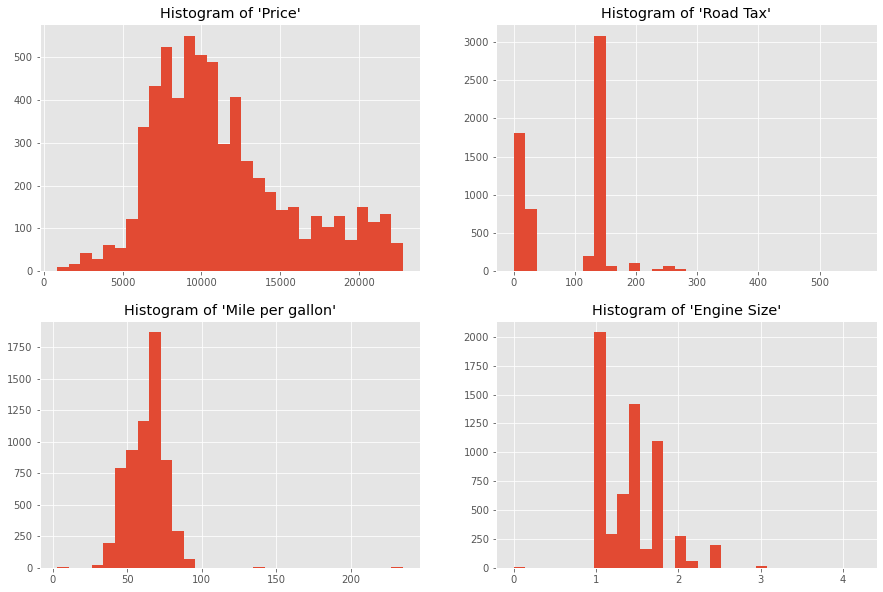

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig,a =  plt.subplots(2,2,figsize=(15,10))

sampleDF = car_df4.sample(fraction = 1.0)
price_list = [i[0] for i in car_df4.select("price").collect()]
tax_list = [i[0] for i in car_df4.select("tax").collect()]
mpg_list = [i[0] for i in car_df4.select("mpg").collect()]
engineSize_list = [i[0] for i in car_df4.select("engineSize").collect()]

a[0][0].set_title("Histogram of 'Price'")
a[0][0].hist(price_list, bins= 30)

a[0][1].set_title("Histogram of 'Road Tax'")
a[0][1].hist(tax_list, bins= 30)

a[1][0].set_title("Histogram of 'Mile per gallon'")
a[1][0].hist(mpg_list, bins= 30)

a[1][1].set_title("Histogram of 'Engine Size'")
a[1][1].hist(engineSize_list, bins= 30)

plt.show()

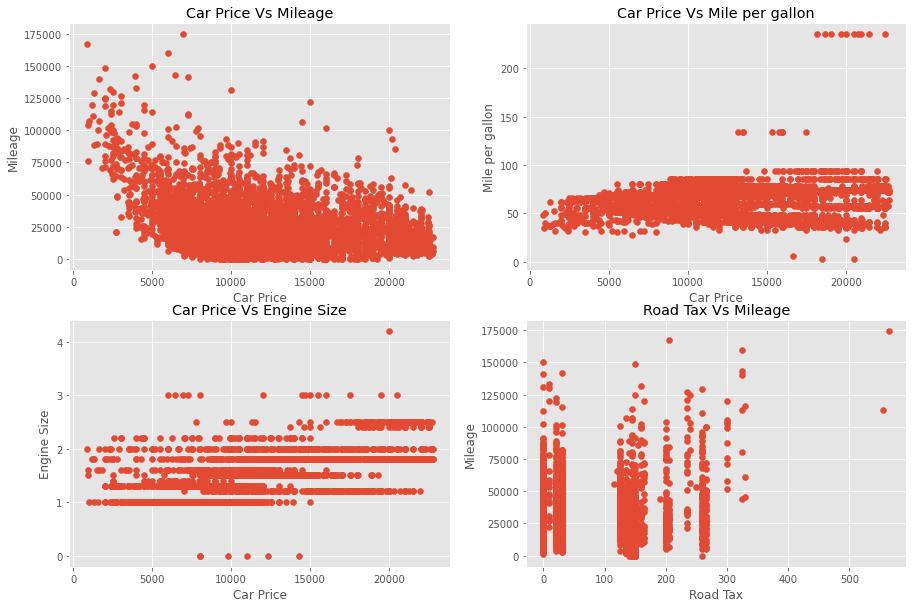

In [24]:
collect_price = [i[0] for i in car_df4.select("price").collect()]
collect_mileage = [i[0] for i in car_df4.select("mileage").collect()]
collect_tax = [i[0] for i in car_df4.select("tax").collect()]
collect_mpg = [i[0] for i in car_df4.select("mpg").collect()]
collect_engineSize = [i[0] for i in car_df4.select("engineSize").collect()]

fig,a =  plt.subplots(2,2,figsize=(15,10))

a[0][0].scatter(collect_price, collect_mileage)
a[0][0].set_title('Car Price Vs Mileage')
a[0][0].set_xlabel('Car Price')
a[0][0].set_ylabel('Mileage')

a[0][1].scatter(collect_price, collect_mpg)
a[0][1].set_title('Car Price Vs Mile per gallon')
a[0][1].set_xlabel('Car Price')
a[0][1].set_ylabel('Mile per gallon')

a[1][0].scatter(collect_price, collect_engineSize)
a[1][0].set_title('Car Price Vs Engine Size')
a[1][0].set_xlabel('Car Price')
a[1][0].set_ylabel('Engine Size')


a[1][1].scatter(collect_tax, collect_mileage)
a[1][1].set_title('Road Tax Vs Mileage')
a[1][1].set_xlabel('Road Tax')
a[1][1].set_ylabel('Mileage')

plt.show()


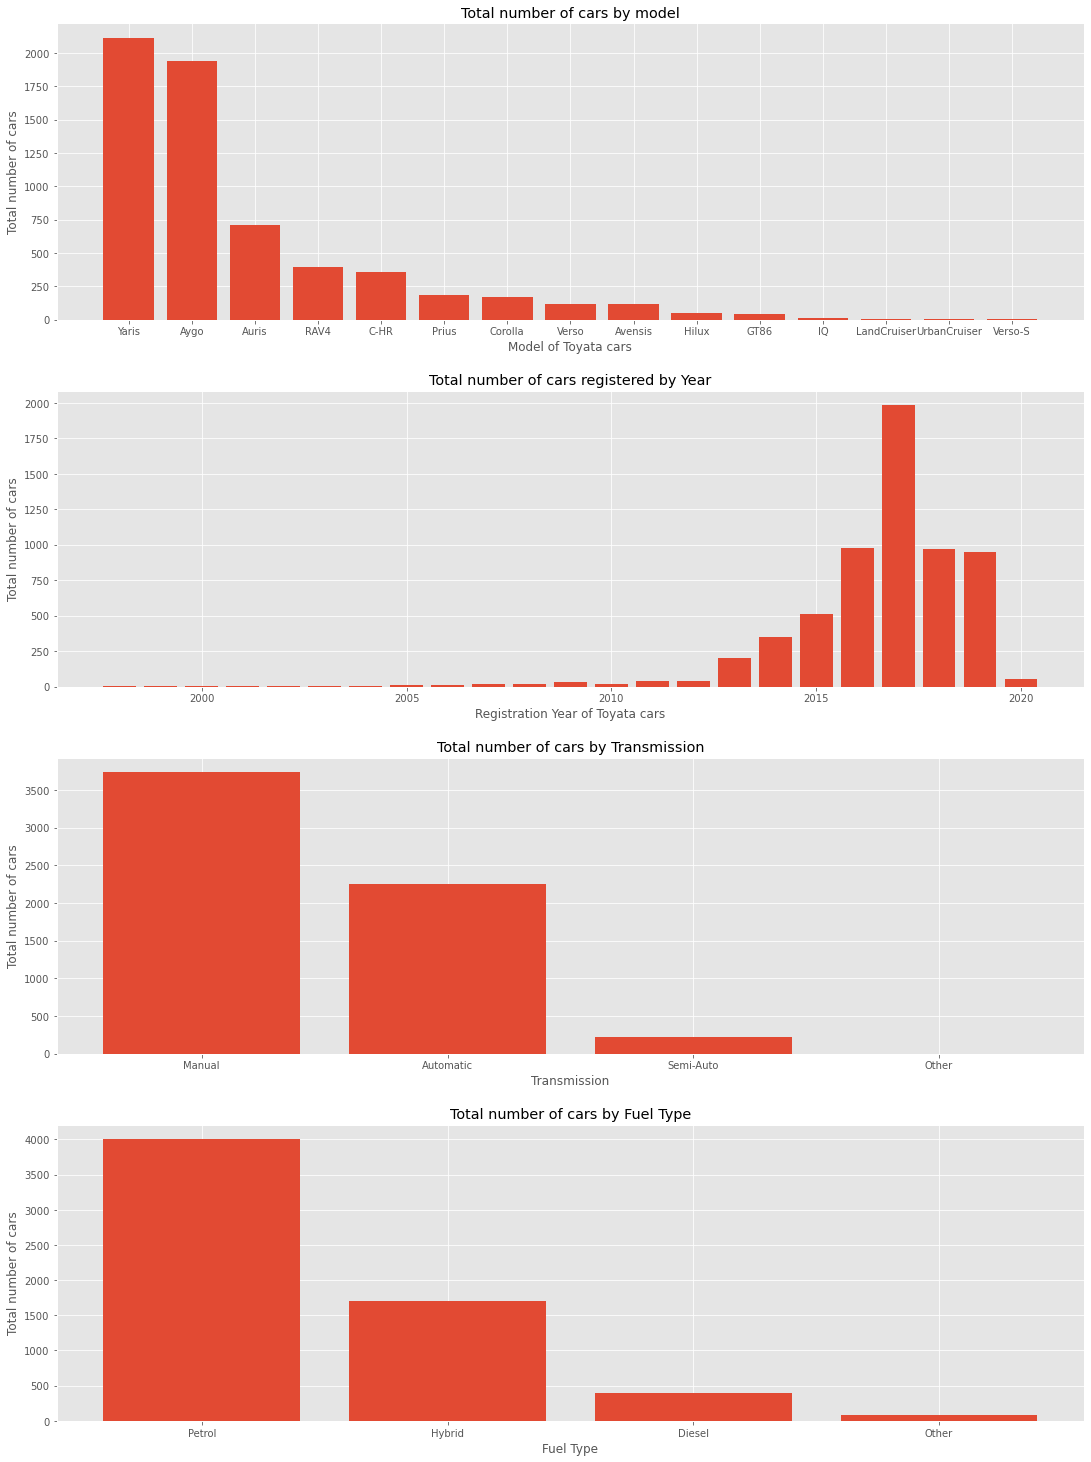

In [25]:
cargrp_model_df = car_df4.groupby("model").count().sort("count", ascending=False)
cargrp_year_df = car_df4.groupby("year").count().sort("count", ascending=False)
cargrp_transmission_df = car_df4.groupby("transmission").count().sort("count", ascending=False)
cargrp_fuelType_df = car_df4.groupby("fuelType").count().sort("count", ascending=False)

collect_model = [i[0] for i in cargrp_model_df.select("model").collect()]
collect_model_count = [i[0] for i in cargrp_model_df.select("count").collect()]

collect_year = [i[0] for i in cargrp_year_df.select("year").collect()]
collect_year_count = [i[0] for i in cargrp_year_df.select("count").collect()]

collect_transmission = [i[0] for i in cargrp_transmission_df.select("transmission").collect()]
collect_transmission_count = [i[0] for i in cargrp_transmission_df.select("count").collect()]

collect_fuelType = [i[0] for i in cargrp_fuelType_df.select("fuelType").collect()]
collect_fuelType_count = [i[0] for i in cargrp_fuelType_df.select("count").collect()]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,20))
fig.tight_layout(h_pad=5, w_pad=5)

ax1.bar(collect_model, collect_model_count)
ax1.set_title('Total number of cars by model')
ax1.set_xlabel('Model of Toyata cars')
ax1.set_ylabel('Total number of cars')

ax2.bar(collect_year, collect_year_count)
ax2.set_title('Total number of cars registered by Year')
ax2.set_xlabel('Registration Year of Toyata cars')
ax2.set_ylabel('Total number of cars')

ax3.bar(collect_transmission, collect_transmission_count)
ax3.set_title('Total number of cars by Transmission')
ax3.set_xlabel('Transmission')
ax3.set_ylabel('Total number of cars')

ax4.bar(collect_fuelType, collect_fuelType_count)
ax4.set_title('Total number of cars by Fuel Type')
ax4.set_xlabel('Fuel Type')
ax4.set_ylabel('Total number of cars')

plt.show()

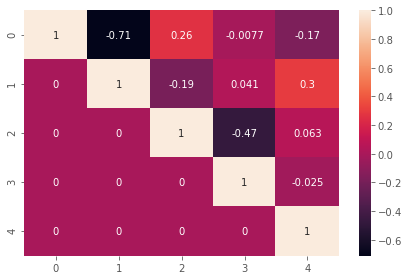

In [26]:
import seaborn as sb
import numpy as np

fig, ax = plt.subplots()

headers = ["year", "mileage", "tax", "mpg", "engineSize"]
n_headers = len(headers)
corr_matrix = []

for i in range(0, n_headers):
    temp = [0] * i
    for j in range(i, n_headers):
        temp.append(car_df4.corr(headers[i], headers[j]))
    corr_matrix.append(temp)

heat_map = sb.heatmap(np.array(corr_matrix), annot=True)
fig.tight_layout()
plt.show()

### Using Multivariate Linear Regression
#### Data transformation
Creating transformation of all the categorical features

In [27]:
import pyspark.ml.feature as ft

model_indexer = ft.StringIndexer(inputCol="model", outputCol="model-num")
model_encoder = ft.OneHotEncoder(inputCol="model-num", outputCol='model-vec')
transmission_indexer = ft.StringIndexer(inputCol="transmission", outputCol="transmission-num")
transmission_encoder = ft.OneHotEncoder(inputCol="transmission-num", outputCol='transmission-vec')
fuelType_indexer = ft.StringIndexer(inputCol="fuelType", outputCol="fuelType-num")
fuelType_encoder = ft.OneHotEncoder(inputCol="fuelType-num", outputCol='fuelType-vec')

Assemble all the relevant columns into a single vector using the VectorAssembler

In [28]:
featuresCreator = ft.VectorAssembler(inputCols=["model-vec", "year", "transmission-vec", 
                                                "mileage", "fuelType-vec", "tax", "mpg", "engineSize"], 
                                     outputCol='features')

#### Creating an Estimator

In [29]:
import pyspark.ml.regression as reg
lr = reg.GeneralizedLinearRegression(labelCol="price")

#### Creating a Pipeline

Next, create a Pipeline to pull the different transformations together.

In [30]:
from pyspark.ml import Pipeline
pipeline = Pipeline( stages = [model_indexer, model_encoder, transmission_indexer, transmission_encoder, 
                               fuelType_indexer, fuelType_encoder, featuresCreator, lr] )

#### Fitting the Model

Split the dataset into training and testing datasets. Use 70% of the dataset for training and the remaining 30% for testing and the seed value 555.

In [46]:
car_train, car_test = car_df4.randomSplit([0.65, 0.35], seed=555)
car_train.persist()

DataFrame[id: int, model: string, year: int, price: int, transmission: string, mileage: int, fuelType: string, tax: int, mpg: double, engineSize: double]

Next, run your pipeline and estimate the model.

In [47]:
model = pipeline.fit(car_train)

#### Evaluating the Performance of the Model

Since we have created our linear regression model, let us use our testing dataset to see how well our model does its predictions:

In [48]:
import pyspark.ml.evaluation as ev

predictions = model.transform(car_test)
evaluator = ev.RegressionEvaluator(predictionCol="prediction", labelCol="price")
print(evaluator.evaluate(predictions, {evaluator.metricName: 'rmse'}))
print(evaluator.evaluate(predictions, {evaluator.metricName: 'r2'}))

1116.3573397253185
0.9357451006417389


#### Using the Predictive Model
used the predictive model to predict the price of any car.

In [49]:
schema = ["model", "year", "transmission", "fuelType", "mileage", "tax", "mpg", "engineSize"]
test_record = [ ( "Yaris", 2014, "Automatic", "Petrol", 45000, 135, 45.3, 1.5 ) ]
df = spark.createDataFrame(test_record, schema=schema)
model.transform(df).first().prediction

8171.612790824613

### Using decision tree for regression

#### Creating an Estimator
Next, we create our decision tree regression model.

In [50]:
import pyspark.ml.regression as reg
dr = reg.DecisionTreeRegressor(labelCol="price")

#### Creating a Pipeline
Next, create a Pipeline to pull the different transformations together.

In [51]:
from pyspark.ml import Pipeline
pipeline = Pipeline( stages = [model_indexer, model_encoder, transmission_indexer, transmission_encoder,
                               fuelType_indexer, fuelType_encoder, featuresCreator, dr] )

#### Fitting the Model
Split the dataset into training and testing datasets. Use 70% of the dataset for training and the remaining 30% for testing and the seed value 555.

In [58]:
car_train, car_test = car_df4.randomSplit([0.68, 0.32], seed=555)
car_train.persist()

DataFrame[id: int, model: string, year: int, price: int, transmission: string, mileage: int, fuelType: string, tax: int, mpg: double, engineSize: double]

Next, run your pipeline and estimate the model.

In [59]:
model = pipeline.fit(car_train)

#### Evaluating the Performance of the Model
Since we have created our decision tree regression model, let us use our testing dataset to see how well our model does its predictions:

In [60]:
import pyspark.ml.evaluation as ev

predictions = model.transform(car_test)
evaluator = ev.RegressionEvaluator(predictionCol="prediction", labelCol="price")
print(evaluator.evaluate(predictions, {evaluator.metricName: 'rmse'}))
print(evaluator.evaluate(predictions, {evaluator.metricName: 'r2'}))

1471.9880744354737
0.8871349841896771


#### Using the Predictive Model

used the predictive model to predict the price of any car.

In [61]:
schema = ["model", "year", "transmission", "fuelType", "mileage", "tax", "mpg", "engineSize"]
test_record = [ ( "Yaris", 2014, "Automatic", "Petrol", 45000, 135, 45.3, 1.5 ) ]
df = spark.createDataFrame(test_record, schema=schema)
model.transform(df).first().prediction

9867.541984732825

### Using Gradient-Boosted Trees for Regression (GBTs)
#### Creating an Estimator
Next, we create our Gradient-Boosted tree regression model.

In [62]:
import pyspark.ml.regression as reg
gbt = reg.GBTRegressor(labelCol="price")

#### Creating a Pipeline

Next, create a Pipeline to pull the different transformations together.

In [63]:
from pyspark.ml import Pipeline
pipeline = Pipeline( stages = [model_indexer, model_encoder, transmission_indexer, transmission_encoder,
                               fuelType_indexer, fuelType_encoder, featuresCreator, gbt] )

#### Fitting the Model

Split the dataset into training and testing datasets. Use 70% of the dataset for training and the remaining 30% for testing and the seed value 555.

In [68]:
car_train, car_test = car_df4.randomSplit([0.65, 0.35], seed=555)
car_train.persist()

DataFrame[id: int, model: string, year: int, price: int, transmission: string, mileage: int, fuelType: string, tax: int, mpg: double, engineSize: double]

Next, run your pipeline and estimate the model.

In [69]:
model = pipeline.fit(car_train)

#### Evaluating the Performance of the Model

Since we have created our gradient-boosted tree regression model, let us use our testing dataset to see how well our model does its predictions:

In [70]:
import pyspark.ml.evaluation as ev

predictions = model.transform(car_test)
evaluator = ev.RegressionEvaluator(predictionCol="prediction", labelCol="price")
print(evaluator.evaluate(predictions, {evaluator.metricName: 'rmse'}))
print(evaluator.evaluate(predictions, {evaluator.metricName: 'r2'}))

1073.9485256270543
0.9405342753230884


#### Using the Predictive Model

used the predictive model to predict the price of any car.

In [71]:
schema = ["model", "year", "transmission", "fuelType", "mileage", "tax", "mpg", "engineSize"]
test_record = [ ( "Yaris", 2014, "Automatic", "Petrol", 45000, 135, 45.3, 1.5 ) ]
df = spark.createDataFrame(test_record, schema=schema)
model.transform(df).first().prediction

9521.615486622519

### Using Random Forests Trees for Regression
#### Creating an Estimator

Next, we create our Random Forests tree regression model.

In [72]:
import pyspark.ml.regression as reg
rf = reg.RandomForestRegressor(labelCol="price")

#### Creating a Pipeline

Next, create a Pipeline to pull the different transformations together.

In [73]:
from pyspark.ml import Pipeline
pipeline = Pipeline( stages = [model_indexer, model_encoder, transmission_indexer, transmission_encoder,
                               fuelType_indexer, fuelType_encoder, featuresCreator, rf] )

#### Fitting the Model

Split the dataset into training and testing datasets. Use 70% of the dataset for training and the remaining 30% for testing and the seed value 555.

In [74]:
car_train, car_test = car_df4.randomSplit([0.7, 0.3], seed=555)
car_train.persist()

DataFrame[id: int, model: string, year: int, price: int, transmission: string, mileage: int, fuelType: string, tax: int, mpg: double, engineSize: double]

Next, run your pipeline and estimate the model.

In [75]:
model = pipeline.fit(car_train)

#### Evaluating the Performance of the Model

Since we have created our random forests tree regression model, let us use our testing dataset to see how well our model does its predictions:

In [76]:
import pyspark.ml.evaluation as ev

predictions = model.transform(car_test)
evaluator = ev.RegressionEvaluator(predictionCol="prediction", labelCol="price")
print(evaluator.evaluate(predictions, {evaluator.metricName: 'rmse'}))
print(evaluator.evaluate(predictions, {evaluator.metricName: 'r2'}))

1406.2819606856863
0.8982327120973942


#### Using the Predictive Model

used the predictive model to predict the price of any car.


In [77]:
schema = ["model", "year", "transmission", "fuelType", "mileage", "tax", "mpg", "engineSize"]
test_record = [ ( "Yaris", 2014, "Automatic", "Petrol", 45000, 135, 45.3, 1.5 ) ]
df = spark.createDataFrame(test_record, schema=schema)
model.transform(df).first().prediction

8765.18425629505